# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Image 10

In [4]:
image_path:str = "test_images/10.E.png"

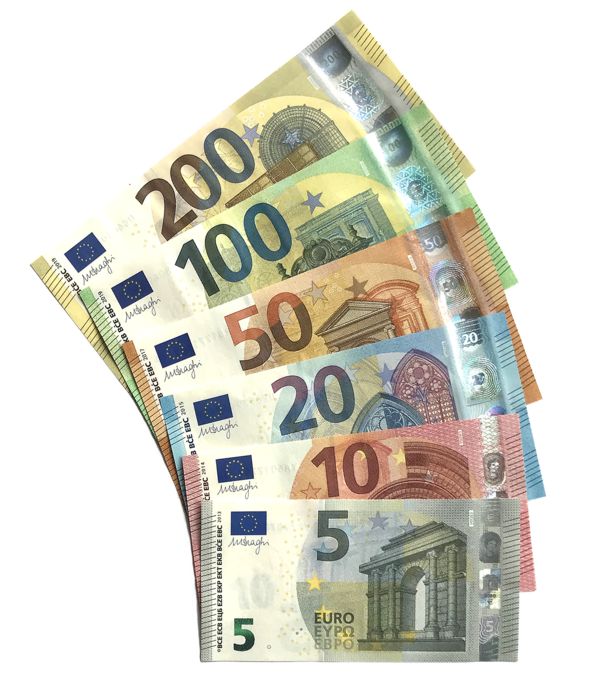

In [5]:
image = Image.open(image_path)
image2 = image.resize((600,int(600*image.height/image.width)))
image2

In [6]:
prompt :str = "<image>\nDescribe this picture concisely."

In [7]:
response(image_path,prompt)

Generated text:

The image displays a pile of various 50. The scene shows a pile of assorted European
 consists money bills of colorful bank European user
 picture
stack user
There is a pile of Deutsche user
A user
The image
There is a pile of Euro user
The image
The image user
There is a pile of European user
A depict
The image of European user
The image
The image
The image
The image displays
There is a pile of 50 euros user
The image features of bank
The image displays user
The image consists user
There is a pile of 50 images
The image consists user
The image depicts 
The image features of various
The image features consists
The image depicts user
The image depicts a pile of European is a pile consists
The image displays
The picture consists user
There is a consists
The image shows a pile consists
The image consists of the pile of euros
The image features the pile consists of money consists of 50 images displays The pile of 20 bills consists of European consists of 50 bank consists o

In [8]:
prompt :str = "<image>\nHow many denominations of banknotes are in the picture, and what is the total amount?"

In [9]:
response(image_path,prompt)

Generated text:

There are five different denominations of banknotes in the banknotes in the picture 20. The image
 and a images of banknotes in the picture in the picture pictures in the image pictures displayed, and a picture, and a picture, and a picture, and the total the total bills. The total amount shown 500. The total amount is 5000.50. The0. There are shown 2000000000000 euros, with aare00.
